In [1]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyIEEM.models.utils import initialize_model

In [103]:
country = 'SWE'
spatial = True
age_classes = pd.IntervalIndex.from_tuples([(0,5),(5,10),(10,15),(15,20),(20,25),(25,30),(30,35),(35,40),(40,45),(45,50),(50,55),(55,60),(60,65),(65,70),(70,75),(75,80),(80,120)], closed='left')
simulation_start = '2020-03-01'
model = initialize_model(country, age_classes, spatial, simulation_start, contact_type='absolute_contacts')

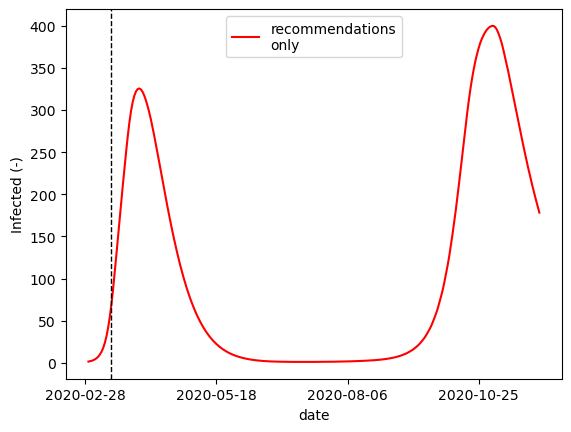

In [105]:
fig,ax = plt.subplots()

model.parameters['zeta'] = 100

# parameter estimates
pars = ['tau', 'ypsilon_eff', 'phi_eff', 'ypsilon_work', 'phi_work', 'ypsilon_leisure', 'phi_leisure', 'amplitude']
thetas = [1.29622186e+01, 6.21760218e-01, 4.96343021e-02, 1.67679210e+01, 1.00939834e-02, 1.47134829e+01, 1.57029663e-01, 3.77772349e-01]

# assign parameter estimates
for par, theta in zip(pars, thetas):
    model.parameters[par] = theta
    
# # economic lockdown, schools closed, preventive measures, social restrictions
# policies_df = pd.read_csv(f'../data/interim/eco/policies/policies_{country}.csv', index_col=[0], header=[0])
# model.parameters['economy_BE_lockdown_1'].loc[slice(None)] = policies_df['lockdown_1']
# model.parameters['economy_BE_phaseI'].loc[slice(None)] = policies_df['lockdown_release_phaseI']
# model.parameters['economy_BE_lockdown_Antwerp'].loc[slice(None)] = policies_df['lockdown_Antwerp']
# model.parameters['economy_BE_lockdown_2'].loc[slice(None)] = policies_df['lockdown_2']
# out = model.sim([simulation_start, '2020-12-01'])
# ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), color='green', label='lockdown')

# # economic lockdown, schools open, preventive measures, social restrictions
# model.parameters['economy_BE_lockdown_1'].loc['P85'] = 0
# out = model.sim([simulation_start, '2020-12-01'])
# ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), 'orange', label='lockdown (schools open)')

# #do-nothing
# model.parameters['economy_BE_lockdown_1'].loc[slice(None)] = 0
# model.parameters['economy_BE_phaseI'].loc[slice(None)] = 0
# model.parameters['economy_BE_lockdown_Antwerp'].loc[slice(None)] = 0
# model.parameters['economy_BE_lockdown_2'].loc[slice(None)] = 0
out = model.sim([simulation_start, '2020-12-01'])
ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), color='red', label='recommendations\nonly')

ax.legend()
ax.axvline(x=datetime(2020, 3, 15), color='black', linestyle='--', linewidth=1)
ax.set_xlabel('date')
ax.set_ylabel('Infected (-)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

#plt.savefig(f'scenarios_{country}.png', dpi=600)
plt.show()
plt.close()

In [118]:
def compute_beta(R0, delta, gamma, s, N, demography):
    beta_i = R0/(s*(delta+gamma)*np.expand_dims(np.sum(N, axis=0),axis=1))
    return sum(np.squeeze(beta_i)*demography/sum(demography))

In [121]:
N = np.squeeze(model.parameters['N']['other'] + model.parameters['G']*model.parameters['N']['work'])
demography = pd.read_csv(f'../data/interim/epi/demographic/age_structure_{country}_2019.csv', index_col=[0, 1]).groupby(by='age').sum().squeeze()
demography = demography.groupby(pd.cut(demography.index.values, age_classes)).sum()
compute_beta(2.75, model.parameters['delta'], model.parameters['gamma'], model.parameters['s'], N, demography.values)

0.02733129308543969